# elapid's Geospatial Features

This notebook reviews common patterns for working with vector and raster data using `elapid`.

We'll review the core tools used for extracting raster data from points and polygons, assigning sample weights based on sample density, and creating spatially-explicit train/test data, while also showing general patterns for working with the `GeoDataFrame` and `GeoSeries` classes from `geopandas`, which are frequently used.

The sample data we'll use includes species occurrence records from the genus *Ariolimax*, a group of North American terrestrial slugs, as well as some climate and vegetation data.

Several datasets used here are hosted on a web server. These files can be accessed locally with `ela.download_sample_data()`, but we'll work with them directly on the web to demonstrate that reading remote data is nearly identical to reading local data thanks to the amazing libraries `elapid` is built on top of.

## Packages, paths & preferences

In [1]:
# packages
import elapid as ela

import os
import warnings
from pprint import pprint
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot as rioplot
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# paths
https = "https://earth-chris.github.io/images/research"
csv = f"{https}/ariolimax-ca.csv"
gpkg = f"{https}/ariolimax-ca.gpkg"
raster_names = [
    "ca-cloudcover-mean.tif",
    "ca-cloudcover-stdv.tif",
    "ca-leafareaindex-mean.tif",
    "ca-leafareaindex-stdv.tif",
    "ca-surfacetemp-mean.tif",
    "ca-surfacetemp-stdv.tif",
]
rasters = [f"{https}/{raster}" for raster in raster_names]
labels = ["CloudCoverMean", "CloudCoverStdv", "LAIMean", "LAIStdv", "SurfaceTempMean", "SurfaceTempStdv"]

In [3]:
# preferences
mpl.style.use('ggplot')
warnings.filterwarnings("ignore")
pair_colors = ['#FFCC02', '#00458C']

print(f"Notebook last run with elapid version {ela.__version__}")

Notebook last run with elapid version 0.3.19


## Working with Point-format data

Species distribution modeling is the science and the art of working with point-format species occurrence data. These are locations on the landscape where a species has been observed and identified and recorded as present in an x/y location. We then model the relative likelihood of observing that species in other locations based on the environmental conditions where that species is observed.

Occurrence data are typically recorded with latitude/longitude coordinates for a single location, also known as "point-format data." Environmental data are typically provided as image data with coordinate reference information, or "raster data." `elapid` provides a series of tools for working with these datasets.

### Reading vector files

Point-format data are most commonly provided in formats like GeoPackage, GeoJSON, or Shapefiles. You can read these into memory easily with `geopandas`.

In [4]:
gdf = gpd.read_file(gpkg)
print(gdf.head())

             species  year                        geometry
0  Ariolimax buttoni  2005  POINT (432271.994 4348048.850)
1  Ariolimax buttoni  2005  POINT (643606.559 4427302.366)
2  Ariolimax buttoni  2006  POINT (537588.166 4194012.740)
3  Ariolimax buttoni  2007  POINT (468489.994 4361538.275)
4  Ariolimax buttoni  2007  POINT (537466.797 4194096.065)


### Reading x/y data

Not all datasets are packaged so conveniently. SDM data often come as CSV files with a column for latitude and longitude, for eample. We can convert that information into a `GeoDataFrame` so we can natively perform geospatial operations.

The example CSV is a subset of this [GBIF occurrence dataset](https://www.gbif.org/occurrence/download/0272645-220831081235567), which contains data from four species of Banana Slug across California.

In [5]:
# read and preview the data
df = pd.read_csv(csv)

# we convert the lat/lon columns into a GeoSeries dataset, which is spatially aware
geometry = ela.xy_to_geoseries(
    x = df['decimalLongitude'],
    y = df['decimalLatitude']
)

# then merge the two together into a GeoDataFrame
ariolimax = gpd.GeoDataFrame(df[["species", "year"]], geometry=geometry)

# show the evolution
print("DataFrame")
print(df.head())
print("\nGeoSeries")
print(geometry.head())
print("\nGeoDataFrame")
print(ariolimax.head())

DataFrame
             species  year  decimalLatitude  decimalLongitude
0  Ariolimax buttoni  2022        37.897280       -122.709870
1  Ariolimax buttoni  2020        39.331897       -123.784692
2  Ariolimax buttoni  2022        37.934980       -122.636929
3  Ariolimax buttoni  2022        38.032908       -122.721855
4  Ariolimax buttoni  2022        38.042295       -122.876520

GeoSeries
0    POINT (-122.70987 37.89728)
1    POINT (-123.78469 39.33190)
2    POINT (-122.63693 37.93498)
3    POINT (-122.72186 38.03291)
4    POINT (-122.87652 38.04230)
dtype: geometry

GeoDataFrame
             species  year                     geometry
0  Ariolimax buttoni  2022  POINT (-122.70987 37.89728)
1  Ariolimax buttoni  2020  POINT (-123.78469 39.33190)
2  Ariolimax buttoni  2022  POINT (-122.63693 37.93498)
3  Ariolimax buttoni  2022  POINT (-122.72186 38.03291)
4  Ariolimax buttoni  2022  POINT (-122.87652 38.04230)


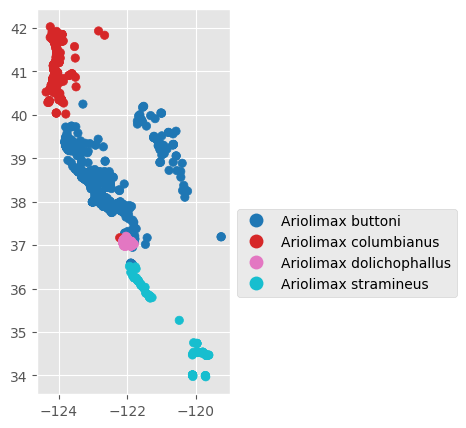

In [6]:
# plot the points geographically by species
fig, ax = plt.subplots(figsize=(5,5))
sp = ariolimax.plot(
    column='species',
    ax=ax,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1, 0.5)}
)

### Converting from arrays to coordinates

Or if you're working with coordinate data in memory, say as an array or a list, `xy_to_geoseries` works with pretty much any iterable type.

In [7]:
# a couple of dummy locations
lons = [-122.49, 151.0]
lats = [37.79, -33.87]

# it's smart to explicity set the CRS/projection to ensure the points are put in the right place
# the CRS below assigns the points the lat/lon crs type
crs = "EPSG:4326"
random_locations = ela.xy_to_geoseries(lons, lats, crs=crs)

# these points now have lots of neat geographic methods and properties
xmin, ymin, xmax, ymax = random_locations.total_bounds
print(f"Bounding box: [{xmin}, {ymin}, {xmax}, {ymax}]")

# including getting a description of the coordinate reference system (crs)
print("")
pprint(random_locations.crs)

Bounding box: [-122.49, -33.87, 151.0, 37.79]

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



## Working with raster data

This demo includes 6 raster files defined at the start of the notebook, corresponding to the average and standard deviation in annual cloud cover, temperature, and vegetation growth across California.

Following a brief overview of the rasters, the sections below will review how to extract data from them using point and polygon vector data.

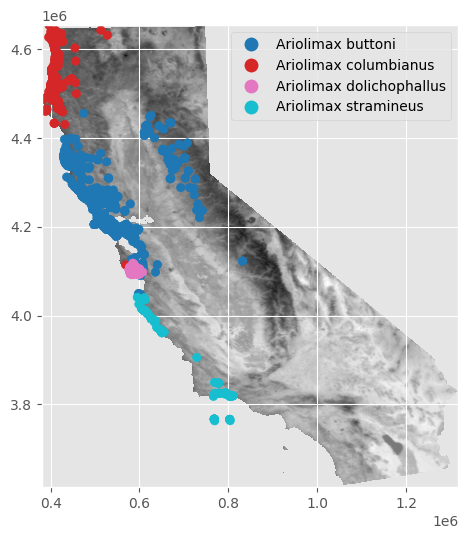

In [8]:
# first we'll just read and display the surface temperature data
fig, ax = plt.subplots(figsize=(6,6))
surfacetemp_raster = rasters[4]
with rio.open(surfacetemp_raster, 'r') as src:
    profile = src.profile.copy()
    
    # this plots the mean annual temperature data
    # low temps are dark grey, high temps are light grey
    rioplot.show(src, ax=ax, cmap="gray")
    
    # overlay the ariolimax data
    ariolimax.to_crs(src.crs).plot(column='species', ax=ax, legend=True)

In [9]:
print("profile metadata")
pprint(profile)

profile metadata
{'blockxsize': 512,
 'blockysize': 512,
 'compress': 'lzw',
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 1040,
 'interleave': 'band',
 'nodata': -9999.0,
 'tiled': True,
 'transform': Affine(1000.0, 0.0, 380000.0,
       0.0, -1000.0, 4654000.0),
 'width': 938}


## Drawing random pseudoabsence locations

In addition to species occurrence records (where `y = 1`), species distributions models often require a set of random pseudo-absence/background points (`y = 0`). These are a random geographic sampling of where you might expect to find a species across the target landscape.

The background point distribution is extremely important for presence-only models, and should be selected with care. `elapid` provides a range of methods for sample selection.

For the unintiated, these papers by [Morgane Barbet-Massin et al.](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2011.00172.x) and [Phillips et al.](https://esajournals.onlinelibrary.wiley.com/doi/abs/10.1890/07-2153.1) are excellent resources to consult for considering how background point samples should be selected.

### From a raster's extent

You can use `elapid` to create a uniform random geographic sample from unmasked locations within a raster's extent:

count                       10000
unique                       9900
top       POINT (1101500 3835500)
freq                            2
dtype: object

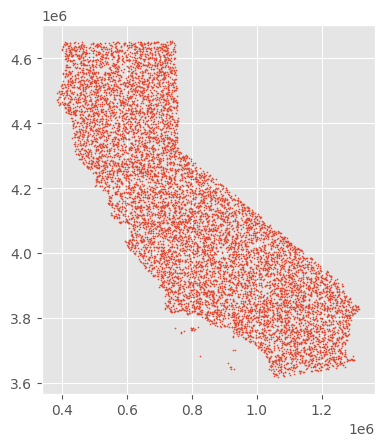

In [10]:
# sampling
count = 10_000
pseudoabsence = ela.sample_raster(surfacetemp_raster, count)

# plotting
pseudoabsence.plot(markersize=0.5)
pseudoabsence.describe()

In [11]:
# some pixel centroids were sampled multiple times
# you can drop them if you'd like.
#pseudoabsence.drop_duplicates(inplace=True)

If you have a large raster that doesn't fit in memory, you can also set `ignore_mask=True` to use the rectangular bounds of the raster to draw samples. Many of the sample locations will be in `nodata` locations but we can address that later.

count                                            10000
unique                                           10000
top       POINT (1170726.4330178155 4110318.773780853)
freq                                                 1
dtype: object

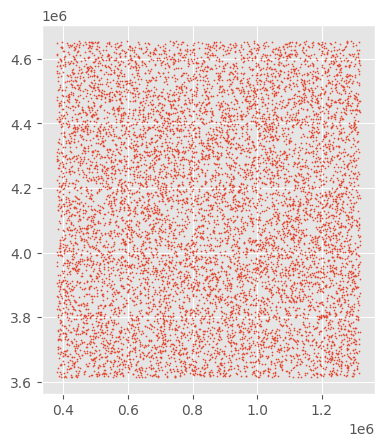

In [12]:
# sampling
pseudoabsence_uniform = ela.sample_raster(
    surfacetemp_raster,
    count,
    ignore_mask=True,
)

# plotting
pseudoabsence_uniform.plot(markersize=0.5)
pseudoabsence_uniform.describe()

### From a bias raster

You could also provide a "bias" file, where the raster grid cells contain information on the probability of sampling an area. Bias adjustments are recommended because species occurrence records are often biased towards certain locations (near roads, parks, or trails).

The grid cells can be an arbitrary range of values. What's important is that the values encode a linear range of numbers that are higher where you're more likely to draw a sample. The probability of drawing a sample is dependent on two factors: the range of values provided and the frequency of values across the dataset.

Because slugs are detrivores, we'll guess that people only go looking for *Ariolimax* in places with lots of vegetation growth. We'll use the leaf area index (LAI) covariate to select more background samples from highly vegetated areas.

count                      10000
unique                      9780
top       POINT (708500 4136500)
freq                           3
dtype: object

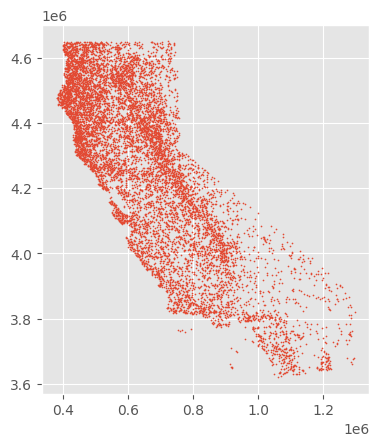

In [13]:
lai_raster = rasters[2]
pseudoabsence_bias = ela.sample_bias_file(lai_raster, count)
pseudoabsence_bias.plot(markersize=0.5)
pseudoabsence_bias.describe()

In [14]:
# again, duplicates can be dropped
# (this can take some time to run)
#pseudoabsence_bias.drop_duplicates(inplace=True)

We can see that we are selecting a disproportionately high number of points along California's coast - home to dense redwood forests where slugs thrive - and disproportionately few samples in the dry deserts in the southeast.

### From a vector polygon

Another way to address bias would be to only select points inside area where that species is known to occur (within a certain ecoregion, for example).

The *Ariolimax* dataset contains occurrence records for four species within the genus. If we're interested in understanding the distributions of only one of them, we could construct a rudimentary "range map" for this genus by computing the bounding geometry of all points then sampling within those bounds.

<AxesSubplot:>

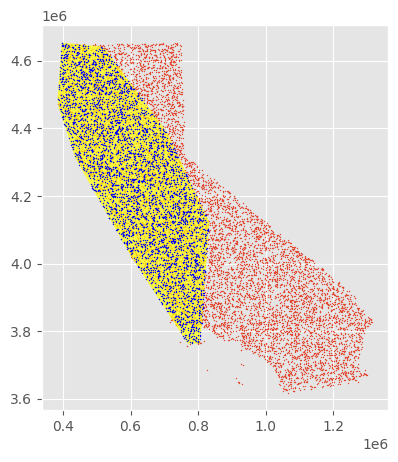

In [15]:
# create a convex hull of all points by merging them into a single multipoint feature
target_crs = pseudoabsence.crs
ariolimax_hull = gpd.GeoSeries(ariolimax.to_crs(target_crs).unary_union.convex_hull).set_crs(target_crs)
pseudoabsence_range = ela.sample_geoseries(ariolimax_hull, count // 2)

# plot 'em together
fig, ax = plt.subplots(figsize=(5, 5))
pseudoabsence.plot(markersize=0.25, ax=ax)
ariolimax_hull.plot(color='yellow', alpha=0.7, ax=ax)
pseudoabsence_range.plot(color='blue', ax=ax, markersize=0.25)

The yellow polygon above shows the simple "range map," the blue points are point samples selected from within that range, and the red points are the uniform sample, plotted for reference.

## Point annotation

Annotation refers to extracting raster values at the each point occurrence record and storing those records together in a `GeoDataFrame`. Once you have your presence and pseudo-absence records, you can annotate these records with the corresponding covariate data.

This function, since it's geographically indexed, doesn't require the point data and the raster data to be in the same projection. `elapid` handles reprojection and resampling on the fly.

It also allows you to pass multiple raster files, which can be in different projections, extents, or grid sizes. This means you don't have to explicitly re-sample your raster data prior to analysis, which is always a chore.

In [16]:
# we'll work with just the Ariolimax buttoni records moving forward
buttoni = ariolimax[ariolimax['species'] == 'Ariolimax buttoni']
presence = ela.annotate(
    buttoni.geometry,
    rasters,
    labels=labels,
    drop_na=True,
)

# we'll use the biased sample locations
background = ela.annotate(
    pseudoabsence_bias,
    rasters,
    labels=labels,
    drop_na=True
)

Raster:   0%|                              | 0/6 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1647 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1647 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1647 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1647 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1647 [00:00<?, ?it/s]

Sample:   0%|                              | 0/1647 [00:00<?, ?it/s]

Raster:   0%|                              | 0/6 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

It took about 20 seconds to annotate nearly 12,000 points across six raster datasets hosted on the web. Neat.

If you don't specify the labels, elapid will assign `['b1', 'b2', ..., 'bn']` names to each column.

Setting `drop_na=True` works with raster datasets that have nodata values assigned in their metadata. These point locations will be dropped from the output dataframe.

Next let's plot some histograms to understand the similarities and differences between the conditions at presence locations and at background locations.

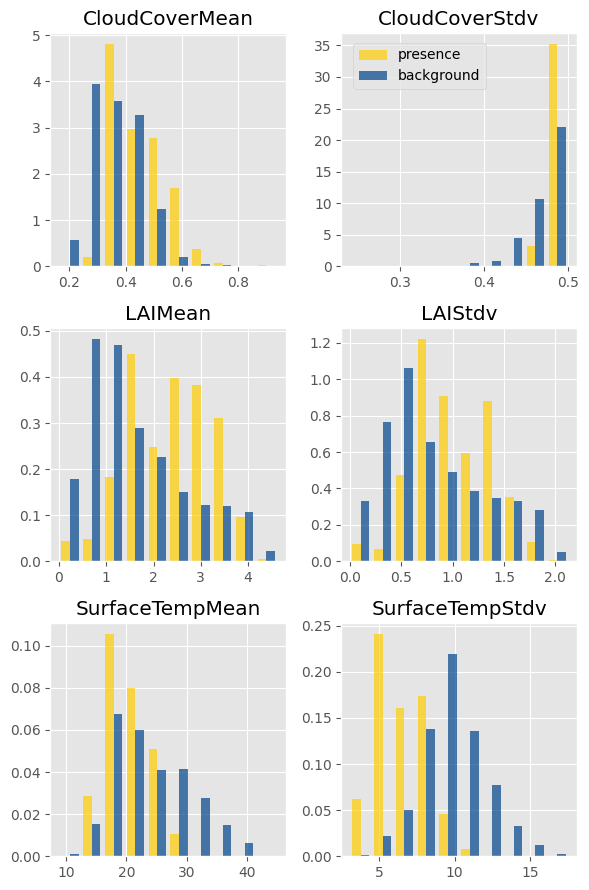

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(6,9))

for label, ax in zip(labels, axs.ravel()):
    pvar = presence[label]
    bvar = background[label]
    ax.hist(
        [pvar, bvar],
        density=True,
        alpha=0.7,
        label=['presence', 'background'],
        color=pair_colors,
    )
    ax.set_title(label)
    
handles, lbls = ax.get_legend_handles_labels()
fig.legend(handles, lbls, loc=(0.6, 0.9))
plt.tight_layout()

This checks out. Slugs are commonly found in areas with higher annual cloud cover, consistently cool temperatures, and high vegetation growth (even after adjusting for bias and oversampling areas with high LAI). Neat!

## Zonal statistics

In addition to the tools for working with Point data, `elapid` contains a routine for calculating zonal statistics from Polygon or MutliPolygon geometry types.

This routine reads an array of raster data covering the extent of a polygon, masks the areas outside the polygon, and computes summary statistics such as the mean, standard deviation, and mode of the array.

The stats reported are managed by a set of keywords (`count=True`, `sum=True`, `skew=True`). The `all=True` keyword is a shortcut to compute all of the stats. You'll still have to explicitly pass a list of percentiles, however.

In [18]:
# compute zonal stats within the generated range map
zs = ela.zonal_stats(
    ariolimax_hull,
    rasters,
    labels = labels,
    mean = True,
    percentiles = [25, 75],
    quiet=True
)

pprint(zs)

   CloudCoverMean_mean  CloudCoverMean_stdv  CloudCoverMean_25pct  \
0             0.350516             0.089797              0.285211   

   CloudCoverMean_75pct  CloudCoverStdv_mean  CloudCoverStdv_stdv  \
0              0.402993             0.468056             0.022682   

   CloudCoverStdv_25pct  CloudCoverStdv_75pct  LAIMean_mean  LAIMean_stdv  \
0              0.451198               0.48941      1.340659      0.883253   

   ...  LAIStdv_75pct  SurfaceTempMean_mean  SurfaceTempMean_stdv  \
0  ...       0.915175             26.174309               6.32528   

   SurfaceTempMean_25pct  SurfaceTempMean_75pct  SurfaceTempStdv_mean  \
0              20.634378              30.810196              9.862017   

   SurfaceTempStdv_stdv  SurfaceTempStdv_25pct  SurfaceTempStdv_75pct  \
0              1.748951               8.830321              11.059798   

                                            geometry  
0  POLYGON ((769358.168 3763373.577, 604251.523 4...  

[1 rows x 25 columns]


What sets the `elapid` zonal stats method apart from other zonal stats packages is it:

- handles reprojection on the fly, meaning the input vector/raster data don't need to be reprojected a priori
- handles mutli-band input, computing summary stats on all bands (instead of having to specify which band)
- handles multi-raster input, reading inputs in serial but creating a single output GeoDataFrame.

## Geographic sample weights

Despite ingesting spatial data, many statistically-driven SDMs are not spatial models in a traditional sense: they don't handle geographic information during model selection or in model scoring.

One way to add spatial information to a model is to compute geographically-explicit sample weights. `elapid` does this by calculating weights based on the distance to the nearest neighbor. Points nearby other points receive lower weight scores; far-away points receive higher weight scores.

The default is to compute weights based on the distance to the nearest point.

<AxesSubplot:>

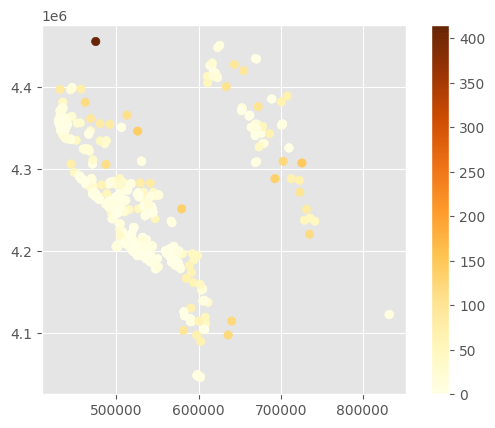

In [19]:
presence['SampleWeight'] = ela.distance_weights(presence)
presence.plot(column='SampleWeight', legend=True, cmap='YlOrBr')

There is one lone point in the northwest corner that is assigned a very high weight because it is so isolated.

Alternatively, you could compute the average distance to `n` nearest points instead to compute sample weights using point densities instead of the distance to the single nearest point. This may be useful if you have small clusters of a few points far away from large, densely populated regions, like the above.

<AxesSubplot:>

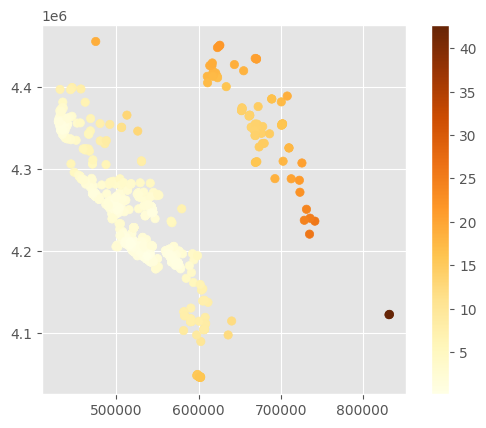

In [20]:
n_neighbors = 100
background['SampleWeight'] = ela.distance_weights(
    background,
    n_neighbors=n_neighbors,
)
presence['SampleWeight'] = ela.distance_weights(
    presence,
    n_neighbors=n_neighbors,
)
presence.plot(column='SampleWeight', legend=True, cmap='YlOrBr')

As you can see, there are tradeoffs for finding the best sample weights depending on the spatial distributions of each occurrence dataset. We'll use a 100 neighbor weight in this case to upweight the samples in the sierras (the northeastern cluster of points).

This function uses `ela.nearest_point_distance()`, a handy function for computing the distance between each point and it's nearest neighbor.

## Stacking dataframes

Now that we have our presence points and our pseudoabsence points, we can merge them together into a single dataset for analysis.

`elapid` provides a convenience function for merging GeoDataFrames, designed for stacking presence/background data. It will reproject geometries on the fly if needed, and you can optionally add a 'class' column to the output GeoDataFrame.

In [21]:
merged = ela.stack_geodataframes(
    presence,
    background,
    add_class_label=True,
)
merged.describe()

,CloudCoverMean,CloudCoverStdv,LAIMean,LAIStdv,SurfaceTempMean,SurfaceTempStdv,SampleWeight,class
count,11584.000000,11584.000000,11584.000000,11584.000000,11584.000000,11584.000000,11584.000000,11584.000000
mean,0.379647,0.475422,1.733374,0.848541,23.629618,9.408598,1.300363,0.137690
std,0.094373,0.024163,1.056482,0.485548,6.155061,2.324037,1.736989,0.344589
min,0.163817,0.240922,0.000000,0.000000,8.792513,3.055165,0.175732,0.000000
25%,0.304788,0.459903,0.886268,0.471768,18.796965,7.998355,0.770930,0.000000
50%,0.374356,0.483275,1.473200,0.742500,22.152232,9.351776,1.000000,0.000000
75%,0.439990,0.495139,2.449682,1.213590,27.945445,10.823034,1.283311,0.000000
max,0.938129,0.500000,4.619103,2.125229,45.100628,17.517273,42.694245,1.000000


## Model setup

We won't get into much detail on model parameters, leaving that for another in-depth notebook. This section will focus on fitting models using default settings, then evaluate the effects of different forms of train/test splitting strategies.

In [22]:
# initialize and print the model defaults
maxent = ela.MaxentModel()
pprint(maxent.get_params())

{'beta_categorical': 1.0,
 'beta_hinge': 1.0,
 'beta_lqp': 1.0,
 'beta_multiplier': 1.5,
 'beta_threshold': 1.0,
 'clamp': True,
 'class_weights': 'balanced',
 'convergence_tolerance': 2e-06,
 'feature_types': ['linear', 'hinge', 'product'],
 'n_cpus': 4,
 'n_hinge_features': 10,
 'n_lambdas': 100,
 'n_threshold_features': 10,
 'scorer': 'roc_auc',
 'tau': 0.5,
 'transform': 'cloglog',
 'use_lambdas': 'best',
 'use_sklearn': False}


In [23]:
# set up the x/y data for model fitting
x = merged.drop(columns=['class', 'SampleWeight'])
y = merged['class']
sample_weight = merged['SampleWeight']

# fit and evaluate the model under naive conditions
maxent.fit(x, y, sample_weight=sample_weight)
ypred = maxent.predict(x)

print(f"Unweighted naive AUC score: {metrics.roc_auc_score(y, ypred):0.3f}")
print(f"Weighted naive AUC score  : {metrics.roc_auc_score(y, ypred, sample_weight=sample_weight):0.3f}")

Unweighted naive AUC score: 0.937
Weighted naive AUC score  : 0.913


## Train / test splits

Uniformly random train/test splits are generally discouraged in spatial modeling because of the strong spatial structure inherent in many datasets. The non-independence of these data is referred to as spatial autocorrelation. Using distance- or density-based sample weights is one way to mitigate these effects. Another is to split the data into geographically distinct train/test regions to try and prioritize model generalization.

### Checkerboard splits

With a "checkerbox" train/test split, points are intersected along a regular grid, and every other grid is used to split the data into train/test sets.

The height and width of the grid used to split the data is controlled by the `grid_size` parameter. This should specify distance in the units of the point data's CRS. In our example, the units are in *meters*.

The black and white structure of the checkerboard means this method can only generate one train/test split.

<AxesSubplot:>

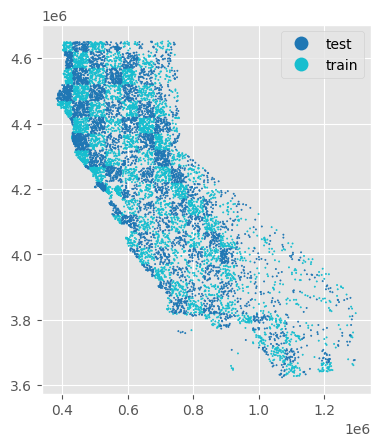

In [24]:
# let's use a 50km grid
grid_size = 50_000
train, test = ela.checkerboard_split(merged, grid_size=grid_size)

# we'll re-merge them for plotting purposes
train['split'] = 'train'
test['split'] = 'test'
checker = ela.stack_geodataframes(train, test)
checker.plot(column='split', markersize=0.75, legend=True)

In [25]:
# set up model fitting
xtrain = train.drop(columns=['class', 'SampleWeight', 'split'])
ytrain = train['class']
sample_weight_train = train['SampleWeight']

xtest = test.drop(columns=['class', 'SampleWeight', 'split'])
ytest = test['class']
sample_weight_test = test['SampleWeight']

maxent.fit(xtrain, ytrain, sample_weight=sample_weight_train)
ypred = maxent.predict(xtest)

print(f"Unweighted checkerboard AUC score: {metrics.roc_auc_score(ytest, ypred):0.3f}")
print(f"Weighted checkerboard AUC score: {metrics.roc_auc_score(ytest, ypred, sample_weight=sample_weight_test):0.3f}")

Unweighted checkerboard AUC score: 0.927
Weighted checkerboard AUC score: 0.882


This lower AUC score is to be expected and should be interpreted as a good thing. It indicates that the naive model was overfitting to nearby points, and the inflated scores were likely the result of spatial autocorrelation.

Future modelers might consider computing sample weights after splitting the train/test data to increase weights at checkerboard edges, which might improve model generalization.

### Geographic *k*-fold splits

Alternatively, you can create `k` geographically-clustered folds using the `GeographicKFold` cross validation strategy. This method is effective for understanding how well models fit in one region will generalize to areas outside the training domain.

This method uses KMeans clusters fit with the x/y locations of the point data, grouping points into spatially distinct groups. This cross-validation strategy is a good way to test how well models generalize outside of their training extents into novel geographic regions.

What makes this tricky is the clustering should only be applied to the presence data. So we'll geographically split the presence data and use a simple background train/test split for each fold.

3-fold xval AUC scores: 0.857, 0.762, 0.883
Test fold


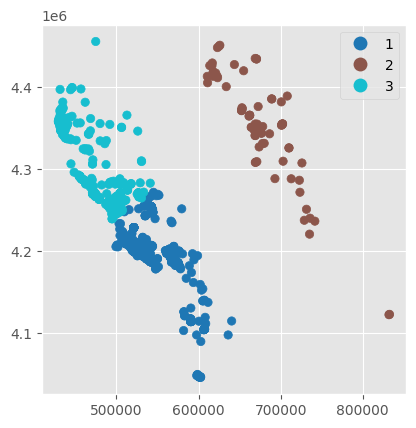

In [26]:
# create lists for plotting, tracking performance
test_dfs = []
auc_scores = []

# split the train / test data
fold = 0
n_splits = 3
gfolds = ela.GeographicKFold(n_splits=n_splits)

for train_idx, test_idx in gfolds.split(presence):
    # this returns arrays for indexing the original dataframe
    # which requires using the pandas .iloc interface
    p_train = presence.iloc[train_idx]
    p_test = presence.iloc[test_idx]
    
    # simple background split
    n_bg_train = len(background) // 2
    b_train = background.iloc[:n_bg_train]
    b_test = background.iloc[n_bg_train:]
    
    # merge 'em
    train = ela.stack_geodataframes(p_train, b_train)
    test = ela.stack_geodataframes(p_test, b_test)
    
    # set up model fitting
    xtrain = train.drop(columns=['class', 'SampleWeight'])
    ytrain = train['class']
    sample_weight_train = train['SampleWeight']
    xtest = test.drop(columns=['class', 'SampleWeight'])
    ytest = test['class']
    sample_weight_test = test['SampleWeight']

    # evaluation
    maxent.fit(xtrain, ytrain, sample_weight=sample_weight_train)
    ypred = maxent.predict(xtest)
    auc = f"{metrics.roc_auc_score(ytest, ypred):0.3f}"
    auc_scores.append(auc)
    
    # store for plotting
    fold += 1
    p_test['fold'] = str(fold)
    test_dfs.append(p_test)

    
print(f"{n_splits}-fold xval AUC scores: {', '.join(auc_scores)}")

folds = gpd.GeoDataFrame(pd.concat(test_dfs, axis=0, ignore_index=True), crs=test.crs)
folds.plot(column='fold', legend=True)
print("Test fold")

The plot above shows the spatial distributions of test folds fom the geographic k-fold splits. The third split - the points in the Sierras to the east - had the lowest test performance. This can be interpreted in several ways, which we won't get into here.

### Buffered leave-one-out

Leave-one-out cross-validation refers to training on *n-1* points and testing on a single test point, looping over the full dataset to test on each point separately.

The buffered leave-one-out strategy, as described by [Ploton et al.](https://www.nature.com/articles/s41467-020-18321-y), modifies this approach. While each point is iterated over for testing, the pool of available training points is reduced at each iteration by dropping training points located within a certain distance of the test data. The purpose of this method is to evaluate how a model performs far away from where it was trained.

In SDM contexts, however, standard leave-one-out strategies may not be appropriate. Model performance is best evaluated on presence-only data; model performance on background points may not be meaningful.

To only run the leave-one-out analysis on presence-only points, specify the column with the 0/1 class labels during train/test splitting:

In [27]:
# let's use Ariolimax stramineus records here (fewer samples)
stramineus = ariolimax[ariolimax['species'] == 'Ariolimax stramineus']
presence = ela.annotate(
    stramineus.geometry,
    rasters,
    labels=labels,
    drop_na=True,
    quiet=True,
)
merged = ela.stack_geodataframes(presence, background, add_class_label=True)

# store the individual sample predictions and evaluate at the end
yobs_scores = []
ypred_scores = []

# buffered leave-one-out, 5km buffer radius
distance = 5_000
bloo = ela.BufferedLeaveOneOut(distance=distance)
for train_idx, test_idx in bloo.split(merged, class_label="class"):
    train = merged.iloc[train_idx]
    test = merged.iloc[test_idx]
    
    # set up model fitting
    xtrain = train.drop(columns=['class'])
    ytrain = train['class']
    xtest = test.drop(columns=['class'])
    ytest = test['class']

    # evaluation
    maxent.fit(xtrain, ytrain)
    ypred = maxent.predict(xtest)
    ypred_scores.append(ypred)
    yobs_scores.append(ytest)

In [28]:
# get model predictions for just the background
bg = merged[merged['class'] == 0]
xbg = bg.drop(columns='class')
ybg = bg['class'].to_numpy()
bg_pred = maxent.predict(xbg)

# concatenate the background and leave-one-out points
bl_pred = np.array(ypred_scores)
bl_obs = np.array(yobs_scores)
ypred = np.vstack((bg_pred.reshape(-1,1), bl_pred))
yobs = np.vstack((ybg.reshape(-1,1), bl_obs))

# evaluate
auc = metrics.roc_auc_score(yobs, ypred)
print(f"Buffered leave-one-out AUC: {auc:0.3f}")

# no buffer
x = merged.drop(columns=['class'])
y = merged['class']
maxent.fit(x, y)
ypred = maxent.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Naive model AUC: {auc:0.3f}")

Buffered leave-one-out AUC: 0.958
Naive model AUC: 0.982


This function also modifies the "leave-one-out" approach to support testing on multiple points per-fold. You may want to run your cross-validation to evaluate test performance across multiple ecoregions, for example.

You can do this by passing the `group` keyword during train/test splitting, and the value should correspond to a column name in the GeoDataFrame you pass.


```python
bloo = ela.BufferedLeaveOneOut(distance=1000)
for train_idx, test_idx in bloo.split(merged, group="ecoregion"):
    train_points = merged.iloc[train_idx]
    test_points = merged.iloc[test_idx]
    # assumes `merged` has an 'ecoregion' column

```

This will find the unique values in the `ecoregion` column and iterate over those values, using the points from each ecoregion as test folds and excluding points within 1000m of those locations from the training data. This should greatly reduce the compute time because the number of leave-one-out iterations will be grouped by region instead of applied to every single point.

This example is simply demonstrative and will not work as-is because this group label doesn't exist for this dataset.